### Advanced data preparation: Build an ‘enriched’ customer profile by deriving “intelligent” KPIs such as:
Monthly average purchase and cash advance amount
 
Purchases by type (one-off, installments)

Average amount per purchase and cash advance transaction,

Limit usage (balance to credit limit ratio),

Payments to minimum payments ratio etc.

### Advanced reporting: Use the derived KPIs to gain insight on the customer profiles.
    1)Identification of the relationships/ affinities between services.
    2)Clustering: Apply a data reduction technique factor analysis for variable reduction technique and a clustering algorithm to reveal the behavioural segments of credit card holders
    3)Identify cluster characterisitics of the cluster using detailed profiling.
    4)Provide the strategic insights and implementation of strategies for given set of cluster characteristics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.decomposition import PCA

In [5]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [6]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [7]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [8]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [61]:
df_cred_det=pd.read_csv('F:/analytix_labs/4. Segmentation of Credit Card Customers/CC_GENERAL.csv')

In [62]:
df_cred_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [83]:
df_cred_det['MON_AVG_PUR']= df_cred_det.PURCHASES /12
df_cred_det['MON_AVG_CASH_ADV']= df_cred_det.CASH_ADVANCE /12
df_cred_det['PAY_MINPAY'] = df_cred_det.PAYMENTS/df_cred_det.MINIMUM_PAYMENTS


#df_cred_det.loc[df_cred_det['PAY_TYPE'] <= 4, 'equal_or_lower_than_4?'] = 'True' 

In [84]:
df_cred_det['PAY_TYPE']= np.where(((df_cred_det.ONEOFF_PURCHASES == 0.00) & (df_cred_det.INSTALLMENTS_PURCHASES > 0.00)),'INSTALL',
                                 np.where(((df_cred_det.ONEOFF_PURCHASES > 0) & (df_cred_det.INSTALLMENTS_PURCHASES == 0)) ,'ONEOFF','NOPAY'))

In [85]:
df_cred_det[['MON_AVG_PUR','PURCHASES','MON_AVG_CASH_ADV','CASH_ADVANCE','MINIMUM_PAYMENTS','PAYMENTS','PAY_MINPAY','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','PAY_TYPE']]

,MON_AVG_PUR,PURCHASES,MON_AVG_CASH_ADV,CASH_ADVANCE,MINIMUM_PAYMENTS,PAYMENTS,PAY_MINPAY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PAY_TYPE
0,7.950000,95.40,0.000000,0.000000,139.509787,201.802084,1.446508,0.00,95.40,INSTALL
1,0.000000,0.00,536.912124,6442.945483,1072.340217,4103.032597,3.826241,0.00,0.00,NOPAY
2,64.430833,773.17,0.000000,0.000000,627.284787,622.066742,0.991682,773.17,0.00,ONEOFF
3,124.916667,1499.00,17.149001,205.788017,NaN,0.000000,NaN,1499.00,0.00,ONEOFF
4,1.333333,16.00,0.000000,0.000000,244.791237,678.334763,2.771075,16.00,0.00,ONEOFF
...,...,...,...,...,...,...,...,...,...,...
8945,24.260000,291.12,0.000000,0.000000,48.886365,325.594462,6.660231,0.00,291.12,INSTALL
8946,25.000000,300.00,0.000000,0.000000,NaN,275.861322,NaN,0.00,300.00,INSTALL
8947,12.033333,144.40,0.000000,0.000000,82.418369,81.270775,0.986076,0.00,144.40,INSTALL
8948,0.000000,0.00,3.046565,36.558778,55.755628,52.549959,0.942505,0.00,0.00,NOPAY


In [86]:
df_cred_det

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MON_AVG_PUR,MON_AVG_CASH_ADV,PAY_MINPAY,PAY_TYPE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,...,2,1000.0,201.802084,139.509787,0.000000,12,7.950000,0.000000,1.446508,INSTALL
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,...,0,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,536.912124,3.826241,NOPAY
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,...,12,7500.0,622.066742,627.284787,0.000000,12,64.430833,0.000000,0.991682,ONEOFF
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,...,1,7500.0,0.000000,NaN,0.000000,12,124.916667,17.149001,NaN,ONEOFF
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,...,1,1200.0,678.334763,244.791237,0.000000,12,1.333333,0.000000,2.771075,ONEOFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,...,6,1000.0,325.594462,48.886365,0.500000,6,24.260000,0.000000,6.660231,INSTALL
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,...,6,1000.0,275.861322,NaN,0.000000,6,25.000000,0.000000,NaN,INSTALL
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,...,5,1000.0,81.270775,82.418369,0.250000,6,12.033333,0.000000,0.986076,INSTALL
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,...,0,500.0,52.549959,55.755628,0.250000,6,0.000000,3.046565,0.942505,NOPAY


In [87]:
## Drop unnecessary variables

df_cred_det.drop(columns='CUST_ID', inplace = True)

In [88]:
### Descriptive Analysis

In [89]:
cred_cont=df_cred_det.loc[:,df_cred_det.columns.difference(['PAY_TYPE'])]

In [90]:
cred_cat=df_cred_det['PAY_TYPE'].reset_index()

In [91]:
cred_cont.apply(continuous_var_summary)

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,MON_AVG_CASH_ADV,MON_AVG_PUR,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PAY_MINPAY,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
N,8.950000e+03,8950.000000,8.950000e+03,8950.000000,8950.000000,8.949000e+03,8.950000e+03,8.637000e+03,8950.000000,8950.000000,8.950000e+03,8950.000000,8.950000e+03,8637.000000,8950.000000,8.950000e+03,8950.000000,8950.000000,8950.000000,8950.000000
NMISS,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000e+00,3.130000e+02,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,313.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
SUM,1.400205e+07,7851.572994,8.760896e+06,1209.540593,29077.000000,4.022083e+07,3.679055e+06,7.464152e+06,730074.704714,748223.605000,5.302314e+06,1811.996268,1.551164e+07,80756.555660,1375.746104,8.978683e+06,4388.637408,3261.714207,131653.000000,103080.000000
MEAN,1.564475e+03,0.877271,9.788711e+02,0.135144,3.248827,4.494449e+03,4.110676e+02,8.642065e+02,81.572593,83.600403,5.924374e+02,0.202458,1.733144e+03,9.350070,0.153715,1.003205e+03,0.490351,0.364437,14.709832,11.517318
MEDIAN,8.733852e+02,1.000000,0.000000e+00,0.000000,0.000000,3.000000e+03,8.900000e+01,3.123439e+02,0.000000,30.106667,3.800000e+01,0.083333,8.569015e+02,2.170495,0.000000,3.612800e+02,0.500000,0.166667,7.000000,12.000000
STD,2.081532e+03,0.236904,2.097164e+03,0.200121,6.824647,3.638816e+03,9.043381e+02,2.372447e+03,174.763656,178.052898,1.659888e+03,0.298336,2.895064e+03,120.286915,0.292499,2.136635e+03,0.401371,0.397448,24.857649,1.338331
VAR,4.332775e+06,0.056124,4.398096e+06,0.040049,46.575803,1.324098e+07,8.178274e+05,5.628503e+06,30542.335594,31702.834660,2.755228e+06,0.089004,8.381394e+06,14468.941826,0.085556,4.565208e+06,0.161098,0.157965,617.902719,1.791129
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,5.000000e+01,0.000000e+00,1.916300e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000730,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.000000
P1,6.510059e-02,0.090909,0.000000e+00,0.000000,0.000000,5.000000e+02,0.000000e+00,1.952448e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.055825,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.000000
P5,8.814518e+00,0.272727,0.000000e+00,0.000000,0.000000,1.000000e+03,0.000000e+00,7.328201e+01,0.000000,0.000000,0.000000e+00,0.000000,8.998892e+01,0.454553,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.000000


In [92]:
cred_cat.apply(categorical_var_summary)

,index,PAY_TYPE
N,8950.00,8950
NMISS,0.00,0
MODE,0.00,NOPAY
FREQ,1.00,4816
PERCENT,0.01,53.81


In [93]:
cred_cat

,index,PAY_TYPE
0,0,INSTALL
1,1,NOPAY
2,2,ONEOFF
3,3,ONEOFF
4,4,ONEOFF
...,...,...
8945,8945,INSTALL
8946,8946,INSTALL
8947,8947,INSTALL
8948,8948,NOPAY


In [94]:
cred_cont = cred_cont.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.95)))

In [95]:
cred_cont = cred_cont.apply(missing_imputation)

In [24]:
def var_boxplot(x):
    sns.boxplot(x)
    plt.show()
    

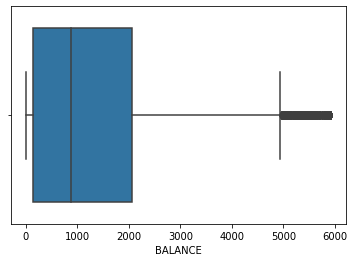

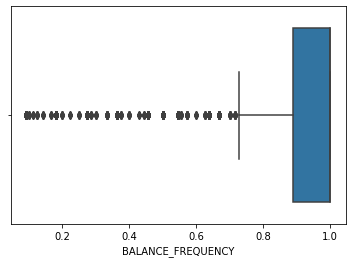

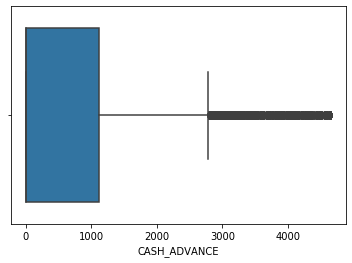

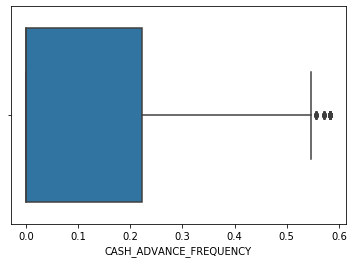

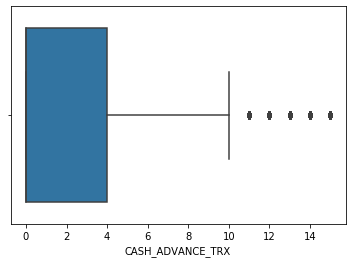

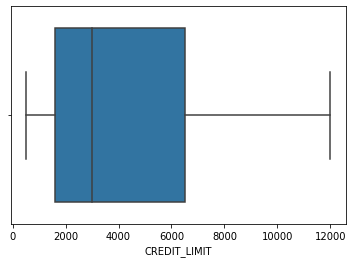

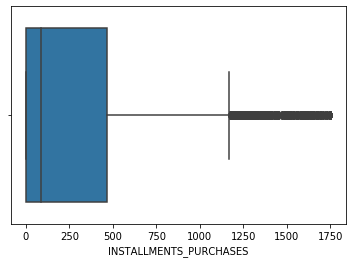

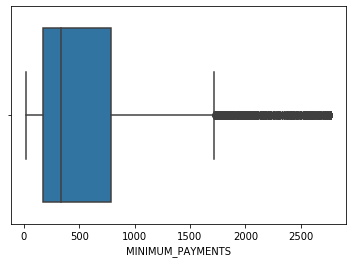

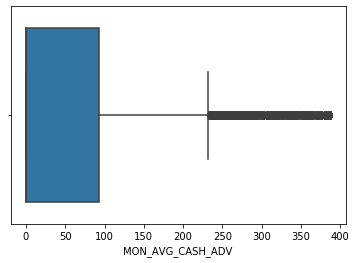

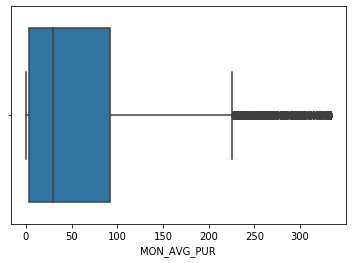

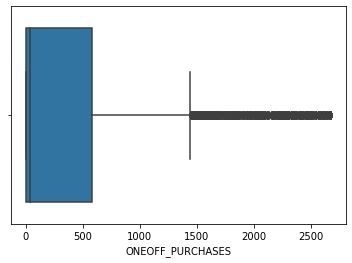

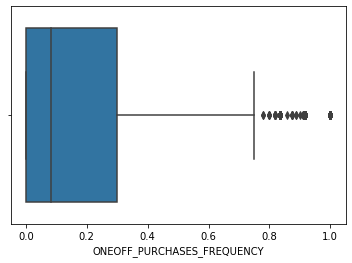

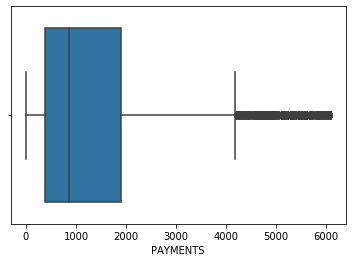

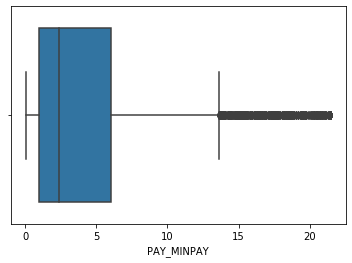

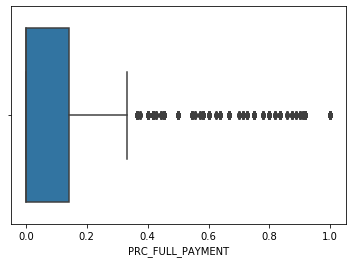

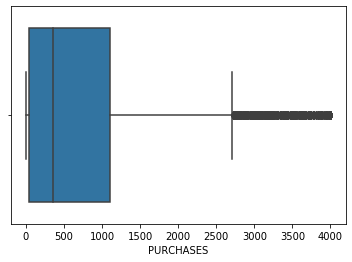

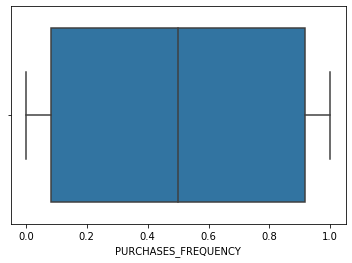

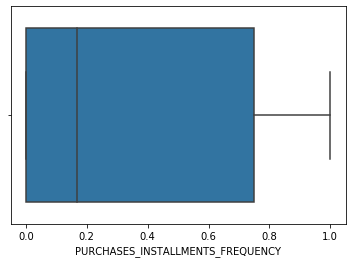

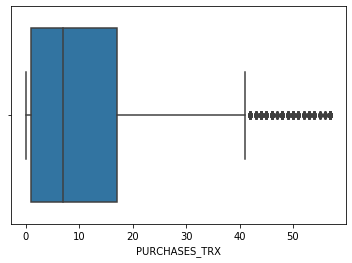

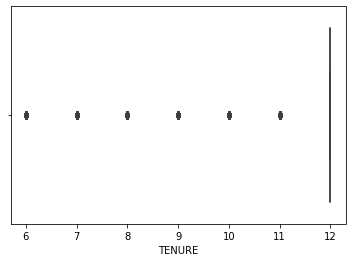

BALANCE                             None
BALANCE_FREQUENCY                   None
CASH_ADVANCE                        None
CASH_ADVANCE_FREQUENCY              None
CASH_ADVANCE_TRX                    None
CREDIT_LIMIT                        None
INSTALLMENTS_PURCHASES              None
MINIMUM_PAYMENTS                    None
MON_AVG_CASH_ADV                    None
MON_AVG_PUR                         None
ONEOFF_PURCHASES                    None
ONEOFF_PURCHASES_FREQUENCY          None
PAYMENTS                            None
PAY_MINPAY                          None
PRC_FULL_PAYMENT                    None
PURCHASES                           None
PURCHASES_FREQUENCY                 None
PURCHASES_INSTALLMENTS_FREQUENCY    None
PURCHASES_TRX                       None
TENURE                              None
dtype: object

In [81]:
cred_cont.apply(var_boxplot)

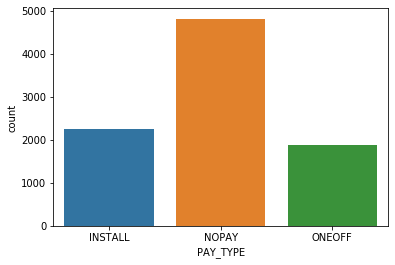

In [83]:
sns.countplot(cred_cat.PAY_TYPE)

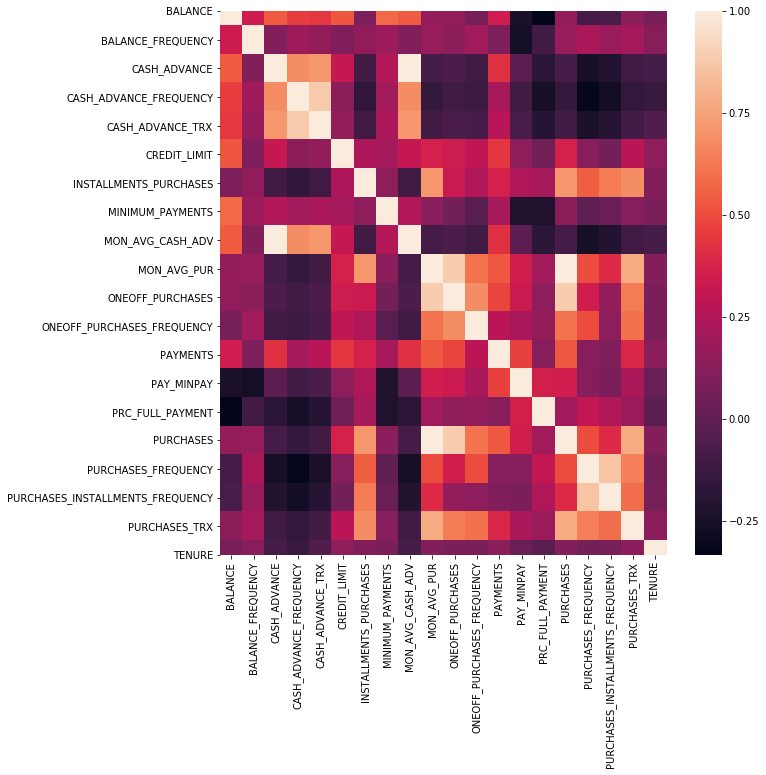

In [123]:
plt.figure(figsize = (10,10))
sns.heatmap(cred_cont.corr())
plt.show()

In [46]:
### Data standardization
### In this case I am only taking the Continuous variables for further analysis

In [96]:
#df_cred_det.shape
cred_cont.shape

(8950, 20)

In [97]:
sc=StandardScaler()

cred_scaled=sc.fit_transform(cred_cont) 

In [98]:
df_cred_scaled=pd.DataFrame(cred_scaled)

In [99]:
df_cred_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03
mean,-6.034403e-16,7.328750e-15,1.343209e-15,9.352668e-16,-1.490087e-15,-5.718455e-15,-4.120131e-15,-1.263223e-15,1.401672e-15,5.104247e-15,1.072175e-14,2.021052e-15,-4.590245e-16,6.528608e-17,-2.201566e-15,5.124641e-15,-3.716084e-16,2.353921e-16,-2.098495e-15,1.556446e-14
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00
min,-8.596897e-01,-3.363725e+00,-6.057071e-01,-7.225024e-01,-6.363807e-01,-1.198012e+00,-6.756417e-01,-8.692174e-01,-6.057071e-01,-7.491355e-01,-6.003935e-01,-6.786608e-01,-9.231327e-01,-8.407075e-01,-5.255510e-01,-7.491355e-01,-1.221758e+00,-9.169952e-01,-8.077983e-01,-4.122768e+00
25%,-7.837797e-01,4.617444e-02,-6.057071e-01,-7.225024e-01,-6.363807e-01,-8.562604e-01,-6.756417e-01,-6.578847e-01,-6.057071e-01,-7.130956e-01,-6.003935e-01,-6.786608e-01,-6.834867e-01,-6.759239e-01,-5.255510e-01,-7.130956e-01,-1.014125e+00,-9.169952e-01,-7.441120e-01,3.606795e-01
50%,-3.426453e-01,5.209700e-01,-6.057071e-01,-7.225024e-01,-6.363807e-01,-4.213045e-01,-4.968559e-01,-4.277869e-01,-6.057071e-01,-4.206250e-01,-5.494615e-01,-3.993193e-01,-3.873494e-01,-4.300004e-01,-5.255510e-01,-4.206250e-01,2.404259e-02,-4.976286e-01,-3.619943e-01,3.606795e-01
75%,3.564141e-01,5.209700e-01,2.198943e-01,5.354039e-01,2.954541e-01,6.660855e-01,2.657711e-01,2.049345e-01,2.198943e-01,2.603015e-01,1.735125e-01,3.269728e-01,2.655640e-01,2.298743e-01,-3.712234e-02,2.603015e-01,1.062211e+00,9.701506e-01,2.748686e-01,3.606795e-01
max,2.638729e+00,5.209700e-01,2.838929e+00,2.579503e+00,2.858000e+00,2.374841e+00,2.839985e+00,2.966949e+00,2.838929e+00,2.886794e+00,2.979721e+00,2.673451e+00,2.879734e+00,2.992947e+00,2.893453e+00,2.886794e+00,1.269843e+00,1.599199e+00,2.822320e+00,3.606795e-01


In [100]:
### Applying PCA

In [101]:
pc = PCA(n_components=20)

In [102]:
pc.fit(cred_scaled)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [103]:
pc.explained_variance_  #Eigen value

array([6.33377081e+00, 4.69920690e+00, 1.91471568e+00, 1.45901452e+00,
       1.11975473e+00, 8.94979593e-01, 7.59530028e-01, 6.11522811e-01,
       5.21641557e-01, 4.50385455e-01, 3.59894640e-01, 2.39260757e-01,
       1.82696199e-01, 1.67441805e-01, 1.39067117e-01, 7.65181600e-02,
       4.66334939e-02, 2.62006299e-02, 5.05725343e-31, 1.76169147e-32])

In [104]:
sum(pc.explained_variance_)

20.002234886579487

In [105]:
#The amount of variance that each PC explains
var= pc.explained_variance_ratio_
var

array([3.16653156e-01, 2.34934092e-01, 9.57250874e-02, 7.29425750e-02,
       5.59814809e-02, 4.47439798e-02, 3.79722582e-02, 3.05727242e-02,
       2.60791636e-02, 2.25167566e-02, 1.79927214e-02, 1.19617012e-02,
       9.13378928e-03, 8.37115482e-03, 6.95257894e-03, 3.82548052e-03,
       2.33141417e-03, 1.30988512e-03, 2.52834419e-32, 8.80747318e-34])

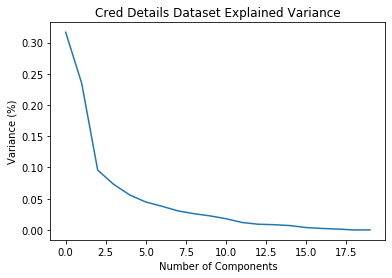

In [36]:
# Screen Plot - Plotting Explained Variance % by each componet
plt.figure()
plt.plot(var)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cred Details Dataset Explained Variance')
plt.show()

In [106]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pc.explained_variance_ratio_, decimals=4)*100)
var1

array([ 31.67,  55.16,  64.73,  72.02,  77.62,  82.09,  85.89,  88.95,
        91.56,  93.81,  95.61,  96.81,  97.72,  98.56,  99.26,  99.64,
        99.87, 100.  , 100.  , 100.  ])

In [107]:
pd.DataFrame({'Eigen_value': np.round(pc.explained_variance_, decimals=4), 'Cumm_variance':var1}, index=range(1,21))

,Eigen_value,Cumm_variance
1,6.3338,31.67
2,4.6992,55.16
3,1.9147,64.73
4,1.4590,72.02
5,1.1198,77.62
6,0.8950,82.09
7,0.7595,85.89
8,0.6115,88.95
9,0.5216,91.56
10,0.4504,93.81


In [108]:
pc_final=PCA(n_components=6).fit(cred_scaled)

In [109]:
pc_final.explained_variance_

array([6.33377081, 4.6992069 , 1.91471568, 1.45901452, 1.11975473,
       0.89497959])

In [110]:
reduced_cr=pc_final.fit_transform(cred_scaled)  # the out put is Factors (F1, F2, ...F9)

In [111]:
dimensions = pd.DataFrame(reduced_cr)

In [112]:
dimensions.columns = ["C1", "C2", "C3", "C4", "C5","C6"]

In [113]:
print(cred_scaled.shape)

print(dimensions.shape)
#pd.DataFrame(telco_scaled).head()
print(dimensions.head())


(8950, 20)
(8950, 6)
         C1        C2        C3        C4        C5        C6
0 -1.673942 -2.199016 -0.267359  0.630545 -0.132152 -0.315195
1 -2.607309  3.400846  1.285477 -0.477756 -1.331773  0.000661
2  1.018138 -0.205303 -0.799269  2.366433  0.725455 -0.351774
3 -0.204621 -0.369016  0.693229  2.159079 -0.321090  0.913876
4 -1.706128 -1.749157 -0.319072  1.016620 -0.090180 -0.692893


In [114]:
Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=cred_cont.columns).T

In [115]:
Loadings

,0,1,2,3,4,5
BALANCE,-0.069618,0.820292,-0.325788,0.199952,-0.125338,0.183396
BALANCE_FREQUENCY,0.175143,0.355831,-0.491797,0.031735,0.214333,-0.515934
CASH_ADVANCE,-0.355728,0.821567,0.186242,-0.239900,0.013573,0.004540
CASH_ADVANCE_FREQUENCY,-0.416720,0.733539,0.097345,-0.205287,0.241812,-0.186342
CASH_ADVANCE_TRX,-0.373963,0.760196,0.102167,-0.232138,0.182254,-0.198215
CREDIT_LIMIT,0.289258,0.542921,0.105288,0.181846,-0.339415,0.228104
INSTALLMENTS_PURCHASES,0.755291,0.106156,-0.195802,-0.388778,-0.159315,0.121718
MINIMUM_PAYMENTS,-0.042374,0.654842,-0.446307,0.147615,-0.214523,0.268821
MON_AVG_CASH_ADV,-0.355728,0.821567,0.186242,-0.239900,0.013573,0.004540
MON_AVG_PUR,0.913548,0.249237,0.070277,0.120060,0.086313,0.067408


In [44]:
### Segmentation/ Clustering

In [116]:
km_3=KMeans(n_clusters=3,random_state=123)
km_3.fit(dimensions)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [117]:
km_4=KMeans(n_clusters=4,random_state=123).fit(dimensions)
km_5=KMeans(n_clusters=5,random_state=123).fit(dimensions)
km_6=KMeans(n_clusters=6,random_state=123).fit(dimensions)
km_7=KMeans(n_clusters=7,random_state=123).fit(dimensions)
km_8=KMeans(n_clusters=8,random_state=123).fit(dimensions)

In [118]:
# save the cluster labels and sort by cluster
cred_cont['cluster_3'] = km_3.labels_
cred_cont['cluster_4'] = km_4.labels_
cred_cont['cluster_5'] = km_5.labels_
cred_cont['cluster_6'] = km_6.labels_
cred_cont['cluster_7'] = km_7.labels_
cred_cont['cluster_8'] = km_8.labels_

In [119]:
cred_cont

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,MON_AVG_CASH_ADV,MON_AVG_PUR,...,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,0.000000,0.000000,0,1000.0,95.40,139.509787,0.000000,7.950000,...,0.166667,0.083333,2,12,2,1,1,2,4,1
1,3202.467416,0.909091,4647.169122,0.250000,4,7000.0,0.00,1072.340217,387.264093,0.000000,...,0.000000,0.000000,0,12,1,2,3,1,1,4
2,2495.148862,1.000000,0.000000,0.000000,0,7500.0,0.00,627.284787,0.000000,64.430833,...,1.000000,0.000000,12,12,2,1,1,2,3,3
3,1666.670542,0.636364,205.788017,0.083333,1,7500.0,0.00,641.962032,17.149001,124.916667,...,0.083333,0.000000,1,12,2,1,1,2,3,3
4,817.714335,1.000000,0.000000,0.000000,0,1200.0,0.00,244.791237,0.000000,1.333333,...,0.083333,0.000000,1,12,2,1,1,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,0.000000,0.000000,0,1000.0,291.12,48.886365,0.000000,24.260000,...,1.000000,0.833333,6,6,2,3,4,0,0,7
8946,19.183215,1.000000,0.000000,0.000000,0,1000.0,300.00,641.962032,0.000000,25.000000,...,1.000000,0.833333,6,6,2,3,4,0,0,7
8947,23.398673,0.833333,0.000000,0.000000,0,1000.0,144.40,82.418369,0.000000,12.033333,...,0.833333,0.666667,5,6,2,3,0,5,0,7
8948,13.457564,0.833333,36.558778,0.166667,2,500.0,0.00,55.755628,3.046565,0.000000,...,0.000000,0.000000,0,6,2,1,0,5,2,7


### Quantative Evaluation of Clustering

### Segment Size check

In [51]:
pd.Series(km_3.labels_).value_counts()/sum(pd.Series(km_3.labels_).value_counts())

2    0.609832
1    0.203128
0    0.187039
dtype: float64

In [52]:
pd.Series(km_4.labels_).value_counts()/sum(pd.Series(km_4.labels_).value_counts())

1    0.412514
3    0.277318
2    0.175307
0    0.134860
dtype: float64

In [53]:
pd.Series(km_5.labels_).value_counts()/sum(pd.Series(km_5.labels_).value_counts())

1    0.304916
4    0.250726
3    0.157430
0    0.156425
2    0.130503
dtype: float64

In [54]:
pd.Series(km_6.labels_).value_counts()/sum(pd.Series(km_6.labels_).value_counts())

2    0.301341
0    0.238659
5    0.153408
1    0.152961
3    0.087486
4    0.066145
dtype: float64

In [55]:
pd.Series(km_7.labels_).value_counts()/sum(pd.Series(km_7.labels_).value_counts())

4    0.265363
0    0.207374
1    0.147151
2    0.145028
3    0.106927
6    0.066927
5    0.061229
dtype: float64

In [56]:
pd.Series(km_8.labels_).value_counts()/sum(pd.Series(km_8.labels_).value_counts())

1    0.248827
2    0.190503
4    0.140559
6    0.131844
3    0.102458
0    0.066480
7    0.061564
5    0.057765
dtype: float64

### Calculating the optimum Clusters using Silhouette Coefficients 

In [114]:
# calculate SC for K=3 through K=12
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(dimensions)
    scores.append(metrics.silhouette_score(dimensions, km.labels_))

In [116]:
scores

[0.3272694479716709,
 0.31459963352212444,
 0.24720922410352938,
 0.2406662488625067,
 0.24190864690280256,
 0.24834194008011565,
 0.260805599564242,
 0.24683415718375804,
 0.2402257762524442,
 0.23213973111123143,
 0.2441318171562162,
 0.24080267850216927,
 0.24601653616915484,
 0.24639040976163074,
 0.23922903358390232,
 0.23712081744323754,
 0.23367574147152187,
 0.22420969023357187]

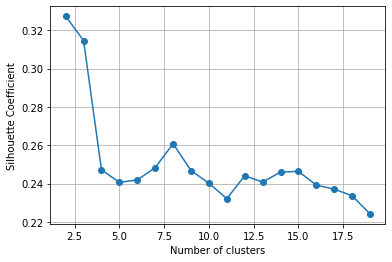

In [117]:
# plot the results
plt.plot(k_range, scores,'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Elbow Analysis

In [119]:
cluster_range = range( 2, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( dimensions )
    cluster_errors.append( clusters.inertia_ )

In [120]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

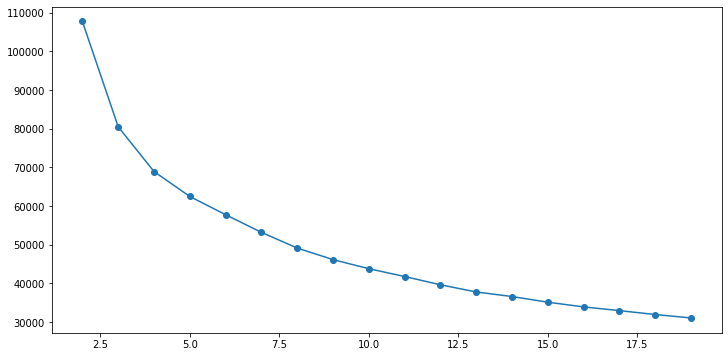

In [121]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

#### Optimum cluster after Quantitative analysis(Cluster Size, Silhouette Coeff, Elbow Analysis) is - 8

### Qualitive Analysis

In [123]:
cred_cont

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,MON_AVG_CASH_ADV,MON_AVG_PUR,...,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,0.000000,0.000000,0,1000.0,95.40,139.509787,0.000000,7.950000,...,0.166667,0.083333,2,12,2,1,1,2,4,1
1,3202.467416,0.909091,4647.169122,0.250000,4,7000.0,0.00,1072.340217,387.264093,0.000000,...,0.000000,0.000000,0,12,1,2,3,1,1,4
2,2495.148862,1.000000,0.000000,0.000000,0,7500.0,0.00,627.284787,0.000000,64.430833,...,1.000000,0.000000,12,12,2,1,1,2,3,3
3,1666.670542,0.636364,205.788017,0.083333,1,7500.0,0.00,641.962032,17.149001,124.916667,...,0.083333,0.000000,1,12,2,1,1,2,3,3
4,817.714335,1.000000,0.000000,0.000000,0,1200.0,0.00,244.791237,0.000000,1.333333,...,0.083333,0.000000,1,12,2,1,1,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,0.000000,0.000000,0,1000.0,291.12,48.886365,0.000000,24.260000,...,1.000000,0.833333,6,6,2,3,4,0,0,7
8946,19.183215,1.000000,0.000000,0.000000,0,1000.0,300.00,641.962032,0.000000,25.000000,...,1.000000,0.833333,6,6,2,3,4,0,0,7
8947,23.398673,0.833333,0.000000,0.000000,0,1000.0,144.40,82.418369,0.000000,12.033333,...,0.833333,0.666667,5,6,2,3,0,5,0,7
8948,13.457564,0.833333,36.558778,0.166667,2,500.0,0.00,55.755628,3.046565,0.000000,...,0.000000,0.000000,0,6,2,1,0,5,2,7


In [126]:
cred_cont.cluster_4.size

8950

In [127]:
size=pd.concat([pd.Series(cred_cont.cluster_3.size), pd.Series.sort_index(cred_cont.cluster_3.value_counts()), pd.Series.sort_index(cred_cont.cluster_4.value_counts()),
           pd.Series.sort_index(cred_cont.cluster_5.value_counts()), pd.Series.sort_index(cred_cont.cluster_6.value_counts()),
           pd.Series.sort_index(cred_cont.cluster_7.value_counts()), pd.Series.sort_index(cred_cont.cluster_8.value_counts())])

In [128]:
size

0    8950
0    1674
1    1818
2    5458
0    1207
1    3692
2    1569
3    2482
0    1400
1    2729
2    1168
3    1409
4    2244
0    2136
1    1369
2    2697
3     783
4     592
5    1373
0    1856
1    1317
2    1298
3     957
4    2375
5     548
6     599
0     595
1    2227
2    1705
3     917
4    1258
5     517
6    1180
7     551
dtype: int64

In [129]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/cred_cont.cluster_3.size, columns=['Seg_Pct'])

In [132]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,1674.000000,1818.000000,5458.000000,1207.00000,3692.000000,1569.000000,2482.000000,1400.000000,2729.000000,...,548.000000,599.000000,595.00000,2227.000000,1705.000000,917.000000,1258.000000,517.000000,1180.000000,551.000000
Seg_Pct,1.0,0.187039,0.203128,0.609832,0.13486,0.412514,0.175307,0.277318,0.156425,0.304916,...,0.061229,0.066927,0.06648,0.248827,0.190503,0.102458,0.140559,0.057765,0.131844,0.061564


In [133]:
cred_cont.apply(lambda x: x.mean()).T

BALANCE                             1452.134450
BALANCE_FREQUENCY                      0.878083
CASH_ADVANCE                         817.161146
CASH_ADVANCE_FREQUENCY                 0.127637
CASH_ADVANCE_TRX                       2.731732
CREDIT_LIMIT                        4356.059686
INSTALLMENTS_PURCHASES               336.336040
MINIMUM_PAYMENTS                     641.962032
MON_AVG_CASH_ADV                      68.096762
MON_AVG_PUR                           68.655252
ONEOFF_PURCHASES                     447.948730
ONEOFF_PURCHASES_FREQUENCY             0.202458
PAYMENTS                            1476.406228
PAY_MINPAY                             4.744917
PRC_FULL_PAYMENT                       0.153715
PURCHASES                            823.863022
PURCHASES_FREQUENCY                    0.490351
PURCHASES_INSTALLMENTS_FREQUENCY       0.364437
PURCHASES_TRX                         12.684022
TENURE                                11.517318
cluster_3                              1

In [134]:
 cred_cont.groupby('cluster_3').apply(lambda x: x.mean()).T

cluster_3,0,1,2
BALANCE,1771.093375,3261.356776,751.675779
BALANCE_FREQUENCY,0.967982,0.945328,0.828112
CASH_ADVANCE,390.053862,2934.796936,242.796127
CASH_ADVANCE_FREQUENCY,0.061146,0.382388,0.063176
CASH_ADVANCE_TRX,1.305257,9.058306,1.061927
CREDIT_LIMIT,6529.917454,6005.457212,3139.928758
INSTALLMENTS_PURCHASES,989.705953,122.489820,207.173562
MINIMUM_PAYMENTS,734.112019,1190.233109,431.076012
MON_AVG_CASH_ADV,32.504488,244.566411,20.233011
MON_AVG_PUR,228.806910,26.183843,33.682578


In [135]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([cred_cont.apply(lambda x: x.mean()).T, cred_cont.groupby('cluster_3').apply(lambda x: x.mean()).T, cred_cont.groupby('cluster_4').apply(lambda x: x.mean()).T,
          cred_cont.groupby('cluster_5').apply(lambda x: x.mean()).T, cred_cont.groupby('cluster_6').apply(lambda x: x.mean()).T,
          cred_cont.groupby('cluster_7').apply(lambda x: x.mean()).T, cred_cont.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [136]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
BALANCE,1452.134450,1771.093375,3261.356776,751.675779,2010.098395,952.125229,3479.055236,643.243577,109.390726,1411.231202,...,4042.808389,703.891240,704.225897,1418.501855,602.050252,1219.054450,3710.988899,4072.910412,100.382100,692.644437
BALANCE_FREQUENCY,0.878083,0.967982,0.945328,0.828112,0.969398,0.792604,0.950455,0.915078,0.429101,0.966793,...,0.991637,0.951139,0.951167,0.970310,0.949045,0.966796,0.956973,0.991839,0.410046,0.774665
CASH_ADVANCE,817.161146,390.053862,2934.796936,242.796127,463.896876,404.457770,3166.951670,117.430890,241.149558,528.107914,...,1217.714864,130.593248,131.471186,559.705052,106.200384,160.016277,3401.641095,1203.913416,218.155696,911.044849
CASH_ADVANCE_FREQUENCY,0.127637,0.061146,0.382388,0.063176,0.069539,0.096535,0.397197,0.031753,0.033687,0.136038,...,0.157520,0.026621,0.026800,0.143461,0.027082,0.043428,0.404785,0.156004,0.025560,0.183099
CASH_ADVANCE_TRX,2.731732,1.305257,9.058306,1.061927,1.541011,1.665493,9.586998,0.563255,0.565000,2.439722,...,3.768248,0.520868,0.524370,2.646161,0.504985,0.767721,9.957870,3.765957,0.463559,3.009074
CREDIT_LIMIT,4356.059686,6529.917454,6005.457212,3139.928758,7203.008963,3229.609967,6385.481971,3364.287333,3650.689285,3078.526933,...,8151.003650,6602.587646,6616.722689,2954.632540,3189.364318,4822.910677,6833.389941,8278.143133,3876.535311,2103.132595
INSTALLMENTS_PURCHASES,336.336040,989.705953,122.489820,207.173562,974.114296,47.468359,142.816345,578.210951,120.584911,41.069285,...,1181.422897,1023.442391,1022.321353,42.299924,661.372416,207.805709,121.095000,1200.342693,126.796506,121.582686
MINIMUM_PAYMENTS,641.962032,734.112019,1190.233109,431.076012,764.141212,461.016418,1265.158746,457.749821,206.447368,605.170556,...,1643.647009,262.979292,263.071294,618.364593,477.626962,500.606664,1337.777807,1626.039860,205.157890,313.704426
MON_AVG_CASH_ADV,68.096762,32.504488,244.566411,20.233011,38.658073,33.704814,263.912639,9.785907,20.095796,44.008993,...,101.476239,10.882771,10.955932,46.642088,8.850032,13.334690,283.470091,100.326118,18.179641,75.920404
MON_AVG_PUR,68.655252,228.806910,26.183843,33.682578,262.017754,21.437660,29.984002,69.305535,26.862314,20.921511,...,256.920346,270.597812,271.160978,11.829967,65.578655,111.406886,26.373075,264.551374,25.571254,23.016691


In [137]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [138]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [139]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,1674.000000,1818.000000,5458.000000,1207.000000,3692.000000,1569.000000,2482.000000,1400.000000,2729.000000,...,548.000000,599.000000,595.000000,2227.000000,1705.000000,917.000000,1258.000000,517.000000,1180.000000,551.000000
Seg_Pct,1.000000,0.187039,0.203128,0.609832,0.134860,0.412514,0.175307,0.277318,0.156425,0.304916,...,0.061229,0.066927,0.066480,0.248827,0.190503,0.102458,0.140559,0.057765,0.131844,0.061564
BALANCE,1452.134450,1771.093375,3261.356776,751.675779,2010.098395,952.125229,3479.055236,643.243577,109.390726,1411.231202,...,4042.808389,703.891240,704.225897,1418.501855,602.050252,1219.054450,3710.988899,4072.910412,100.382100,692.644437
BALANCE_FREQUENCY,0.878083,0.967982,0.945328,0.828112,0.969398,0.792604,0.950455,0.915078,0.429101,0.966793,...,0.991637,0.951139,0.951167,0.970310,0.949045,0.966796,0.956973,0.991839,0.410046,0.774665
CASH_ADVANCE,817.161146,390.053862,2934.796936,242.796127,463.896876,404.457770,3166.951670,117.430890,241.149558,528.107914,...,1217.714864,130.593248,131.471186,559.705052,106.200384,160.016277,3401.641095,1203.913416,218.155696,911.044849
CASH_ADVANCE_FREQUENCY,0.127637,0.061146,0.382388,0.063176,0.069539,0.096535,0.397197,0.031753,0.033687,0.136038,...,0.157520,0.026621,0.026800,0.143461,0.027082,0.043428,0.404785,0.156004,0.025560,0.183099
CASH_ADVANCE_TRX,2.731732,1.305257,9.058306,1.061927,1.541011,1.665493,9.586998,0.563255,0.565000,2.439722,...,3.768248,0.520868,0.524370,2.646161,0.504985,0.767721,9.957870,3.765957,0.463559,3.009074
CREDIT_LIMIT,4356.059686,6529.917454,6005.457212,3139.928758,7203.008963,3229.609967,6385.481971,3364.287333,3650.689285,3078.526933,...,8151.003650,6602.587646,6616.722689,2954.632540,3189.364318,4822.910677,6833.389941,8278.143133,3876.535311,2103.132595
INSTALLMENTS_PURCHASES,336.336040,989.705953,122.489820,207.173562,974.114296,47.468359,142.816345,578.210951,120.584911,41.069285,...,1181.422897,1023.442391,1022.321353,42.299924,661.372416,207.805709,121.095000,1200.342693,126.796506,121.582686
MINIMUM_PAYMENTS,641.962032,734.112019,1190.233109,431.076012,764.141212,461.016418,1265.158746,457.749821,206.447368,605.170556,...,1643.647009,262.979292,263.071294,618.364593,477.626962,500.606664,1337.777807,1626.039860,205.157890,313.704426


In [140]:
Profling_output_final.to_csv('F:/analytix_labs/4. Segmentation of Credit Card Customers/Profiling_output.csv')

In [147]:
cred_cont['cluster_8'].value_counts()

1    2227
2    1705
4    1258
6    1180
3     917
0     595
7     551
5     517
Name: cluster_8, dtype: int64

In [126]:
cred_cont.BALANCE[cred_cont['cluster_8'] == 1]

0         40.900749
4        817.714335
8       1014.926473
14      2772.772734
20      2016.684686
           ...     
8774    2585.246439
8782     459.812734
8785    2133.665075
8789     857.273285
8802     427.905890
Name: BALANCE, Length: 2227, dtype: float64

In [136]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


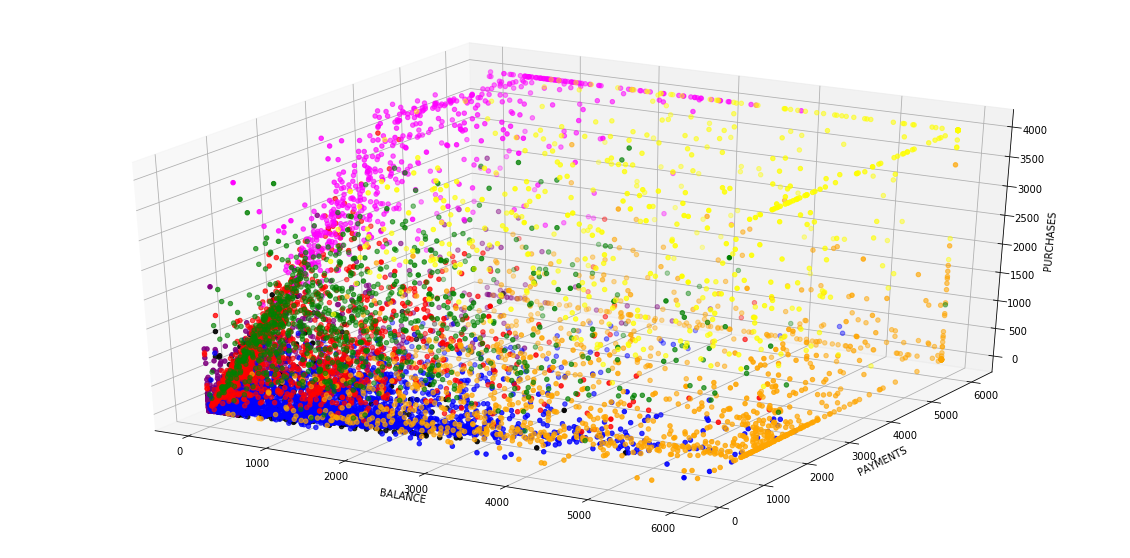

In [153]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax = fig.gca(projection='3d')

ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 0], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 0],cred_cont.PURCHASES[cred_cont['cluster_8'] == 0],c='magenta')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 1], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 1],cred_cont.PURCHASES[cred_cont['cluster_8'] == 1],c='blue')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 2], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 2],cred_cont.PURCHASES[cred_cont['cluster_8'] == 2],c='red')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 3], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 3],cred_cont.PURCHASES[cred_cont['cluster_8'] == 3],c='green')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 4], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 4],cred_cont.PURCHASES[cred_cont['cluster_8'] == 4],c='orange')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 5], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 5],cred_cont.PURCHASES[cred_cont['cluster_8'] == 5],c='yellow')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 6], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 6],cred_cont.PURCHASES[cred_cont['cluster_8'] == 6],c='purple')
ax.scatter(cred_cont.BALANCE[cred_cont['cluster_8'] == 7], cred_cont.PAYMENTS[cred_cont['cluster_8'] == 7],cred_cont.PURCHASES[cred_cont['cluster_8'] == 7],c='black')

ax.set_xlabel("BALANCE")
ax.set_ylabel("PAYMENTS")
ax.set_zlabel('PURCHASES')
plt.show()

### Conclusion : For this study I am consdering 8 Cluster Solution